<a href="https://www.kaggle.com/maximsviridenko/plates-classification?scriptVersionId=84259311" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cleaned vs Dirty

In [1]:
import numpy as np 
import pandas as pd

import os
import zipfile

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import shutil

from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms, models

import time
import copy

In [2]:
BATCH_SIZE = 8
EPOCHS = 200
IMAGE_SIZE = 224

## Подготовка данных

Выведем файлы, которы емы имеем в корневой папке проекта - `input`.

In [3]:
print(os.listdir('../input'))

['platesv2']


Распакуем данные из архива в директорию `working`.

In [4]:
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
   
    zip_obj.extractall('/kaggle/working/')
    
print(os.listdir('/kaggle/working/'))

['__notebook__.ipynb', '__MACOSX', 'plates']


In [5]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


Кажду 6-ю фотографию помести в папку для валидации нашей модели.

In [6]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5390.15it/s]


Подготовим трансформацию изображений для обеих выборок.

In [7]:
train_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ColorJitter(hue=(-0.5,0.5)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Lambda(lambda x: x[np.random.permutation(3), :, :]),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Теперь передадим наши трансформации в `ImageFolder`.

In [8]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

Далее формируем датасеты с размером батча, равным 8-ми.

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Проверим кратность датасетов размеру батча.

In [10]:
len(train_dataloader), len(train_dataset)

(4, 32)

Далее визуализируем наши изображения с учетом методов аугментации.

In [11]:
def show_image_classification(dataloader, title=''):
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    try:
        X_batch, y_batch = next(iter(dataloader))
    except:
        X_batch, y_batch, paths = next(iter(test_dataloader))
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 9))

    for x_item, y_item, i, j in zip(X_batch, y_batch, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
    
        image = x_item.permute(1, 2, 0).numpy()
        image = std * image + mean
        
        title = class_names[y_item]
        
        ax[i, j].imshow(image.clip(0, 1))
        ax[i, j].set_title(title)

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

    fig.tight_layout()
    plt.show()

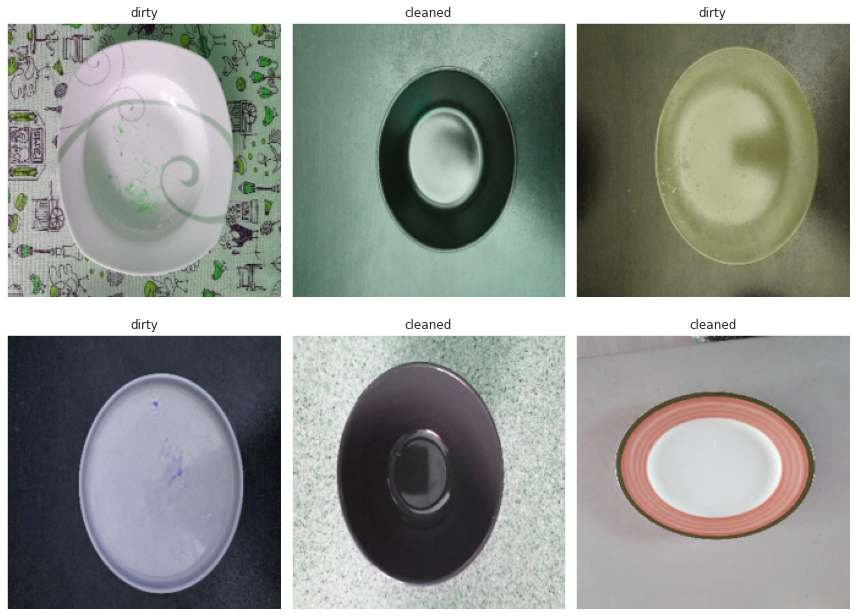

In [12]:
show_image_classification(train_dataloader)

## Модель

Определим модель `ResNet18`. В добавок к этому добавим начальные веса.

In [13]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Обучать мы будем только последний полносвязный слой нашей модели, чтобы сыкономить время обучения.

In [14]:
for param in model.parameters():
    param.requires_grad = False

Далее переопределим последний полносвязный слой, чтобы совершать градиентный спуст только по нему.

In [15]:
model.fc = torch.nn.Linear(model.fc.in_features, 2)

Затем перекладываем модель на `GPU`.

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Определим loss-функцию и метод оптимизации.

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Определим планировщик, который будет изменять шаг градиентного спуска.

In [18]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Обучение

Обучим модель.

In [19]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                valid_loss_history.append(epoch_loss)
                valid_accuracy_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history

In [20]:
model, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history = train_model(
    model, loss, optimizer, scheduler, num_epochs=EPOCHS
);

Epoch 0/199:
train Loss: 1.0376 Acc: 0.4375
val Loss: 0.7859 Acc: 0.6250
Epoch 1/199:
train Loss: 0.7326 Acc: 0.5938
val Loss: 0.8580 Acc: 0.5000
Epoch 2/199:
train Loss: 0.5618 Acc: 0.7500
val Loss: 0.9154 Acc: 0.5000
Epoch 3/199:
train Loss: 0.3860 Acc: 0.7812
val Loss: 0.9590 Acc: 0.5000
Epoch 4/199:
train Loss: 0.4804 Acc: 0.7812
val Loss: 0.9128 Acc: 0.5000
Epoch 5/199:
train Loss: 0.3918 Acc: 0.8125
val Loss: 0.8979 Acc: 0.5000
Epoch 6/199:
train Loss: 0.4085 Acc: 0.8125
val Loss: 0.8999 Acc: 0.5000
Epoch 7/199:
train Loss: 0.3720 Acc: 0.8750
val Loss: 0.8790 Acc: 0.5000
Epoch 8/199:
train Loss: 0.3475 Acc: 0.9062
val Loss: 0.8761 Acc: 0.3750
Epoch 9/199:
train Loss: 0.5545 Acc: 0.7188
val Loss: 0.8555 Acc: 0.3750
Epoch 10/199:
train Loss: 0.3589 Acc: 0.8438
val Loss: 0.8543 Acc: 0.3750
Epoch 11/199:
train Loss: 0.3367 Acc: 0.8750
val Loss: 0.8470 Acc: 0.3750
Epoch 12/199:
train Loss: 0.3992 Acc: 0.8125
val Loss: 0.8434 Acc: 0.3750
Epoch 13/199:
train Loss: 0.3602 Acc: 0.9062
val

In [21]:
dict_data  = {
    'Loss Function Train' : train_loss_history,
    'Loss Function Valid' : valid_loss_history,
    'Accuracy Train' : train_accuracy_history,
    'Accuracy Valid' : valid_accuracy_history
}

In [22]:
df_results = pd.DataFrame.from_dict(dict_data)

In [23]:
def loss_plot(data):
    
    loss_names = data.columns[:2]
    accuracy_names = data.columns[2:]
    legend_names = ['Train', 'Valid']
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, j, k in zip(loss_names, accuracy_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['Loss', 'Accuracy']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Result of Model Training', fontsize=18)
    plt.show()

Посмотрим, как изменялся loss и accuracy нашей модели.

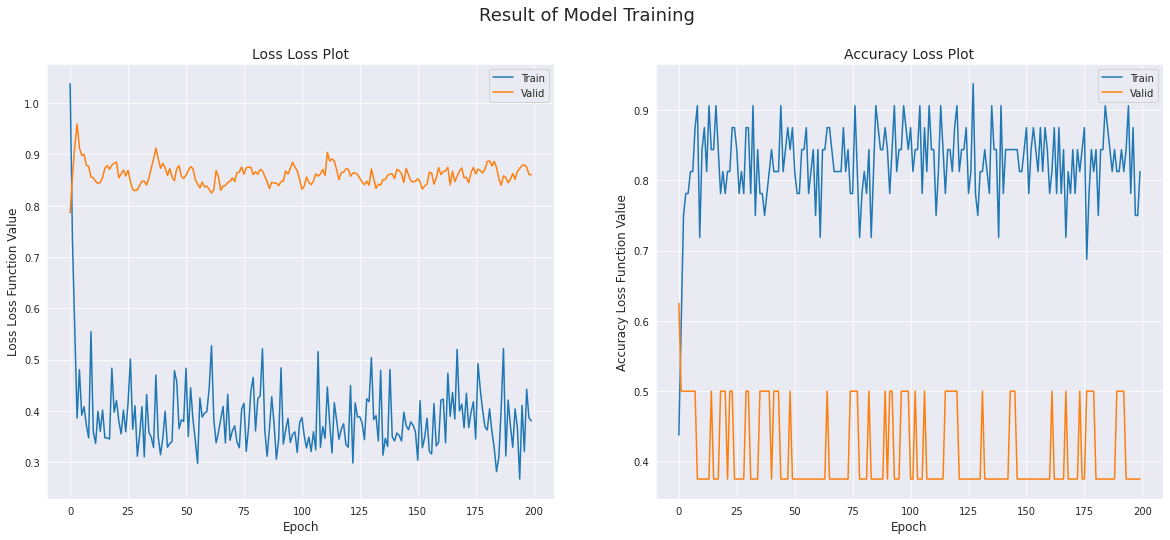

In [24]:
loss_plot(df_results)

## Предсказание модели

In [25]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [26]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [27]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Делаем предсказание.

In [28]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 28.04it/s]


Далее создадим `.csv` наших предсказаний.

In [29]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.25 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


Скачиваем файлы.

In [30]:
submission_df.to_csv('submission.csv')

from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

Очищаем рабочую папку.

In [31]:
!rm -rf train val test